## Import the relevant libraries

In [0]:
import torch
from torch import nn, optim
import pickle
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

## Load the data

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!ls 'gdrive/My Drive/data/hw4/'

hw4_te7.pkl  hw4_tes.pkl  hw4_tr7.pkl  hw4_trs.pkl


In [0]:
with open('gdrive/My Drive/data/hw4/hw4_tr7.pkl', 'rb') as f:
    train_data = torch.tensor(pickle.load(f))

In [0]:
with open('gdrive/My Drive/data/hw4/hw4_te7.pkl', 'rb') as f:
    test_data = torch.tensor(pickle.load(f))

In [6]:
type(train_data), type(test_data)

(torch.Tensor, torch.Tensor)

In [7]:
train_data.shape, test_data.shape

(torch.Size([6265, 28, 28]), torch.Size([1028, 28, 28]))

In [0]:
train_loader = DataLoader(train_data, batch_size=1024)
test_loader = DataLoader(test_data, batch_size=64)

## Plot a few samples

In [0]:
def show_batch(data):
    fig = plt.figure(figsize=(3, 3))
    for idx in np.arange(9):
        ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(data[idx]), cmap='gray')

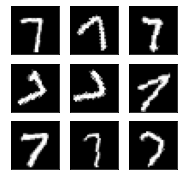

In [10]:
show_batch(train_data)

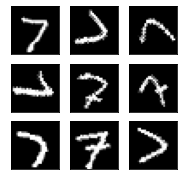

In [11]:
show_batch(test_data)

In [0]:
latent_dims = 4

## Define the model, opt and loss function

In [0]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 256)
        # self.fc12 = nn.Linear(256, 16)
        self.fc13 = nn.Linear(256, 32)
        self.fc21 = nn.Linear(32, latent_dims)
        self.fc22 = nn.Linear(32, latent_dims)
        self.fc3 = nn.Linear(latent_dims, 32)
        self.fc32 = nn.Linear(32, 256)
        # self.fc33 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 784)
    
    def encode(self,x):
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc12(x))
        x = F.relu(self.fc13(x))
        x_mean = self.fc21(x)
        x_var = self.fc22(x)
        return x_mean, x_var
    
    def sample(self, mean, var):
        std = torch.exp(0.5*var)
        eps = torch.randn_like(std)
        return mean + eps*std

    def decode(self, x):
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc32(x))
        # x = F.relu(self.fc33(x))
        x = torch.sigmoid(self.fc4(x))
        return x
    
    def forward(self, x):
        x = x.view(-1,784)
        m, v = self.encode(x)
        z = self.sample(m,v)
        return self.decode(z), m, v

In [0]:
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [15]:
output = model(train_data[:10])
for o in output: print(o.shape)

torch.Size([10, 784])
torch.Size([10, 4])
torch.Size([10, 4])


In [0]:
def Loss(mu,sigma,recon_x,x):
    loss = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
    error = 0
    error = F.binary_cross_entropy(recon_x, x, reduction='sum')
    return loss+error

In [0]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

## Train the model

In [18]:
epochs = 300
loss_list = []
for epoch in range(epochs):
    loss=0
    for images in train_loader:

        batch_size = images.shape[0]
        images = images.view(batch_size, -1).to(device)

        optimizer.zero_grad()
        z,mean,std = model(images)
        batch_loss = Loss(mean,std,z,images)
        loss+=batch_loss.item()
        batch_loss.backward()
        optimizer.step()
    
    # show_batch(z.detach().numpy().reshape(-1,28,28))
    loss_list.append(loss)
    if epoch % 10 == 0:
        print("Train loss for epoch ",epoch,"is", loss)

Train loss for epoch  0 is 2062875.1328125
Train loss for epoch  10 is 996090.529296875
Train loss for epoch  20 is 878038.908203125
Train loss for epoch  30 is 827379.587890625
Train loss for epoch  40 is 798807.0537109375
Train loss for epoch  50 is 790740.279296875
Train loss for epoch  60 is 776505.9560546875
Train loss for epoch  70 is 772935.60546875
Train loss for epoch  80 is 757208.388671875
Train loss for epoch  90 is 756427.455078125
Train loss for epoch  100 is 748188.2744140625
Train loss for epoch  110 is 746319.98828125
Train loss for epoch  120 is 747141.5185546875
Train loss for epoch  130 is 718910.97265625
Train loss for epoch  140 is 708005.2587890625
Train loss for epoch  150 is 702920.3193359375
Train loss for epoch  160 is 693258.6875
Train loss for epoch  170 is 691189.5380859375
Train loss for epoch  180 is 696838.8544921875
Train loss for epoch  190 is 692040.544921875
Train loss for epoch  200 is 681468.6162109375
Train loss for epoch  210 is 697018.15625
Tra

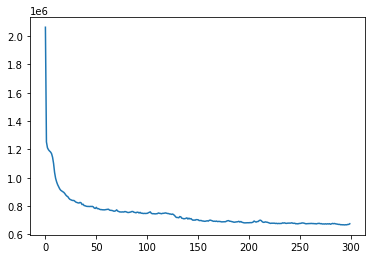

In [19]:
plt.plot(loss_list)
plt.show()

## Generate using random samples

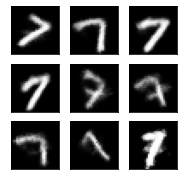

In [22]:
k = torch.randn(10,latent_dims)
output = model.cpu().decode(k)
show_batch(output.detach().numpy().reshape(-1, 28,28))

In [0]:
def check_dims(dim):
    k = torch.randn(10,latent_dims)
    for i in range(latent_dims):
        if i == dim: continue
        else: k[:,i] = k[0][i]
    output = model.decode(k)
    return output.detach().numpy().reshape(-1,28,28)

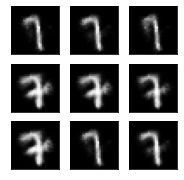

In [24]:
op = check_dims(0)
show_batch(op)

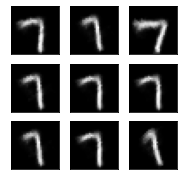

In [25]:
op = check_dims(1)
show_batch(op)

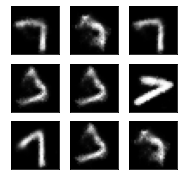

In [26]:
op = check_dims(2)
show_batch(op)

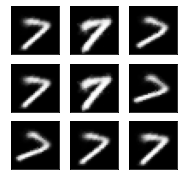

In [27]:
op = check_dims(3)
show_batch(op)

Latent dimension 0 and 3 show the rotation